# Part1 Autoencoders (30 points):

<p>
Your first task is to adapt the code from class to create a CNN-based autoencoder instead of the fully-connected one. 

Take a look at the DCGAN example to see how to use the upconvolution.

Use three conv layers with 32, 64, 128 for the encoder. 

The dimensionality of the latent space should be flexible as an input to the constructor and set per default to 100. 

Use 128, 64, 32 as your symmetric decoder.

Run the autoencoder on MNIST for 20 epochs with Adam and lr=0.001, using the standard MSE loss and with a latent space dimensionality of d = 2.

Now visualize each digit of the trainset of MNIST in the latent space similar to how we did this in class.

What can you say about the clustering of digits? 

Compare this to the fully-connected version from class? 

Do you think the CNN-version of the AE is better??

Re-train the autoencoder with a latent space of d = 10 and d = 50 and compare the MSE-loss for all three autoencoders, as well as discuss the quality of reconstruction.

</p>

In [1]:
%matplotlib inline
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision as tv
from torchvision import transforms, utils
import glob
import pickle
import time
from sklearn.preprocessing import StandardScaler
from scipy.linalg import eigh

In [2]:
class AE_FC(nn.Module):
    def __init__(self, latent_dim):
        super(AE_FC,self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 784)
        )

    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
class AE_FC_deep(nn.Module):

    def __init__(self, latent_dim):
        super(AE_FC_deep,self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784)
        )
        

    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    # we define this function so we can access only the
    # latent space of the model
    def getlatent(self,x):
        x = self.encoder(x)
        return x

In [3]:
class AE_CNN(nn.Module):
    def __init__(self, latent_dim):
        super(AE_CNN, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3,stride=2, padding=1, bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, latent_dim, kernel_size=1, stride=1, padding=1, bias=False), 
            nn.ReLU(),
        )


        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, kernel_size=1, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128), 
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, bias=False),      
            nn.BatchNorm2d(64),      
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1, bias=False),  
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def get_latent(self, x):
        x = self.encoder(x)
        return x

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = tv.datasets.MNIST(root='./',  train=True,download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=1)
testset = tv.datasets.MNIST(root='./', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=1)

In [5]:
def convertBatchToCombined(inp,out):
    # this should be extended to arbitrary batch length
    # assuming this to be 10 here
    combinedUp = np.zeros((28,28*10))
    combinedDown = np.zeros((28,28*10))
    for b in np.arange(10):
        combinedUp[:,b*28:b*28+28]=np.reshape(inp[:,b],(28,28))
        combinedDown[:,b*28:b*28+28]=np.reshape(out[:,b],(28,28))
    tmp = np.vstack([combinedUp,combinedDown])
    tmp = (tmp-tmp.min())/(tmp.max()-tmp.min())*255.
    return(np.repeat(tmp[:,:,np.newaxis], 3, axis=2))


# Fully Connected AutoEncoder

In [6]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from ipywidgets import interact
fig = make_subplots(rows=1, cols=1)
fig.append_trace(go.Image(z=np.zeros((28,28*10,3))),row=1,col=1)
fig = go.FigureWidget(fig)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
)
fig

FigureWidget({
    'data': [{'type': 'image',
              'uid': 'a7a20a65-2b35-4e72-bbbc-515fa218084a',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.],
                           ...,
                           [0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.]],
                   
                          [[0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.],
                           ...,
                           [0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.]],
                   
                          [[0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.],
                           ...,
                           [0., 0., 0.],
                           [0., 0., 0.],
  

In [7]:
num_epochs = 20
model = AE_FC_deep(2)

# put to device
device = (torch.device('cuda') if torch.cuda.is_available()
    else torch.device('cpu'))

model.to(device=device)

# use MSE loss
distance = nn.MSELoss()

# standard ADAM
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# pre-load the test pictures for visualization of online prediction
timg, tlabels = list(dataloader)[0]
timg = timg.to(device)
timg = timg.view(timg.size(0), -1)

# training loop
for epoch in range(num_epochs):
    for n_batch, data in enumerate(dataloader):
        # we don't need the labels here
        img, labels = data[0].to(device), data[1].to(device)

        # flatten
        img = img.view(img.size(0), -1)
        # ===================forward=====================
        output = model(img)
        loss_mse = distance(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss_mse.backward()
        optimizer.step()

        # visualize output
        if (n_batch) % 50 == 0:
            with torch.no_grad():
                output = model(timg)
                inp = timg[0:10, :].detach().cpu()
                out = output[0:10, :].detach().cpu()

                combined = convertBatchToCombined(inp.permute(1,0),out.permute(1,0))

                with fig.batch_update():
                    fig.data[0]['z'] = combined
                    fig.update_layout(
                        title={
                            'text':'epoch {0:} batch {1:} L={2: .3f}'.format(
                                epoch+1,n_batch,loss_mse.item()),
                            'xanchor':'center',
                            'x':0.5
                        })
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss_mse.item()))

epoch [1/20], loss:0.0448
epoch [2/20], loss:0.0429
epoch [3/20], loss:0.0423
epoch [4/20], loss:0.0364
epoch [5/20], loss:0.0394
epoch [6/20], loss:0.0382
epoch [7/20], loss:0.0389
epoch [8/20], loss:0.0376
epoch [9/20], loss:0.0381
epoch [10/20], loss:0.0396
epoch [11/20], loss:0.0343
epoch [12/20], loss:0.0363
epoch [13/20], loss:0.0365
epoch [14/20], loss:0.0371
epoch [15/20], loss:0.0331
epoch [16/20], loss:0.0396
epoch [17/20], loss:0.0355
epoch [18/20], loss:0.0383
epoch [19/20], loss:0.0353
epoch [20/20], loss:0.0374


In [8]:

def train_AE_CNN(num_epochs, latent_dim):
    model = AE_CNN(latent_dim)

    device = (torch.device('cuda') if torch.cuda.is_available()
        else torch.device('cpu'))

    model.to(device=device)

    # use MSE loss
    distance = nn.MSELoss()

    # standard ADAM
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # List to store loss values
    epoch_losses = []
    
    timg, tlabels = list(dataloader)[0]
    timg = timg.to(device)

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        batch_count = 0

        for n_batch, data in enumerate(dataloader):
            # we don't need the labels here
            img, labels = data[0].to(device), data[1].to(device)
            # ===================forward=====================
            output = model(img)
            loss_mse = distance(output, img)
            # ===================backward====================
            optimizer.zero_grad()
            loss_mse.backward()
            optimizer.step()
            
            epoch_loss += loss_mse.item()
            batch_count += 1
            
            # visualize output
            if (n_batch) % 50 == 0:
                with torch.no_grad():
                    output = model(timg)
                    inp = timg[0:10, :].detach().cpu()
                    out = output[0:10, :].detach().cpu()
                    #Since our input has a structure of (128,1,28,28) we need to reshape it to put into model
                    combined = convertBatchToCombined(inp.permute(1,0,2,3),out.permute(1,0,2,3))
                
                    with fig.batch_update():
                        fig.data[0]['z'] = combined
                        fig.update_layout(
                            title={
                                'text':'epoch {0:} batch {1:} L={2: .3f}'.format(
                                    epoch+1,n_batch,loss_mse.item()),
                                'xanchor':'center',
                                'x':0.5
                            })
        average_loss = epoch_loss / batch_count
        epoch_losses.append(average_loss)

        # ===================log========================
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss_mse.item()))
    plt.figure(figsize=(10,10))
    
    dataloaderSorted = torch.utils.data.DataLoader(trainset, batch_size=60000, shuffle=False, num_workers=4)

    for n_batch, data in enumerate(dataloaderSorted):
        img, labels = data[0].to(device), data[1].detach().cpu().numpy()

    # don't forget to do this
    model.eval()
    model.to(device)
    # go through each label
    for l in np.arange(10):
        # find the indices
        inds = labels==l
        # select the images
        tmp = img[inds,:,:,:]
        tmp.to(device)
        # flatten them
        #tmp = tmp.view(tmp.size(0), -1)
        # put them through the model to get their 2D latent
        # space representation
        output = model.get_latent(tmp).detach().cpu().numpy()
        # and scatter giving the label as the digit string
        plt.scatter(output[:,0],output[:,1],label=str(l))

    plt.legend()
    plt.show()
    

    return epoch_losses


In [9]:

import plotly.graph_objs as go
from plotly.subplots import make_subplots
from ipywidgets import interact


fig = make_subplots(rows=1, cols=1)
fig.append_trace(go.Image(z=np.zeros((28,28*10,3))),row=1,col=1)
fig = go.FigureWidget(fig)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.update_layout(
    autosize=False,
    width=1000,
    height=600,
)
fig

FigureWidget({
    'data': [{'type': 'image',
              'uid': '64a2c746-1e44-42b7-a46f-f61026f721e6',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.],
                           ...,
                           [0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.]],
                   
                          [[0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.],
                           ...,
                           [0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.]],
                   
                          [[0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.],
                           ...,
                           [0., 0., 0.],
                           [0., 0., 0.],
  

# Comparing MSE Loss Across Different Latent Dimensions

Training with latent_dim = 2
epoch [1/20], loss:0.0138
epoch [2/20], loss:0.0096
epoch [3/20], loss:0.0090
epoch [4/20], loss:0.0080
epoch [5/20], loss:0.0079
epoch [6/20], loss:0.0079
epoch [7/20], loss:0.0071
epoch [8/20], loss:0.0081
epoch [9/20], loss:0.0054
epoch [10/20], loss:0.0063
epoch [11/20], loss:0.0069
epoch [12/20], loss:0.0064
epoch [13/20], loss:0.0068
epoch [14/20], loss:0.0062
epoch [15/20], loss:0.0063
epoch [16/20], loss:0.0058
epoch [17/20], loss:0.0061
epoch [18/20], loss:0.0057
epoch [19/20], loss:0.0061
epoch [20/20], loss:0.0058


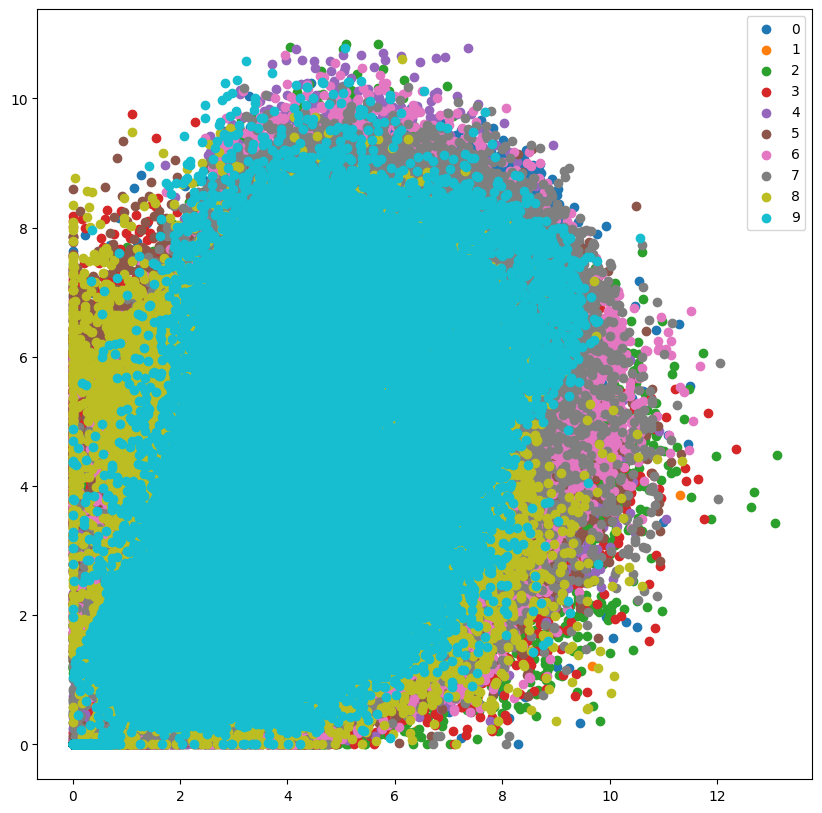

Training with latent_dim = 10
epoch [1/20], loss:0.0032
epoch [2/20], loss:0.0026
epoch [3/20], loss:0.0021
epoch [4/20], loss:0.0020
epoch [5/20], loss:0.0022
epoch [6/20], loss:0.0018
epoch [7/20], loss:0.0015
epoch [8/20], loss:0.0017
epoch [9/20], loss:0.0016
epoch [10/20], loss:0.0015
epoch [11/20], loss:0.0014
epoch [12/20], loss:0.0016
epoch [13/20], loss:0.0014
epoch [14/20], loss:0.0014
epoch [15/20], loss:0.0014
epoch [16/20], loss:0.0015
epoch [17/20], loss:0.0014
epoch [18/20], loss:0.0013
epoch [19/20], loss:0.0014
epoch [20/20], loss:0.0013


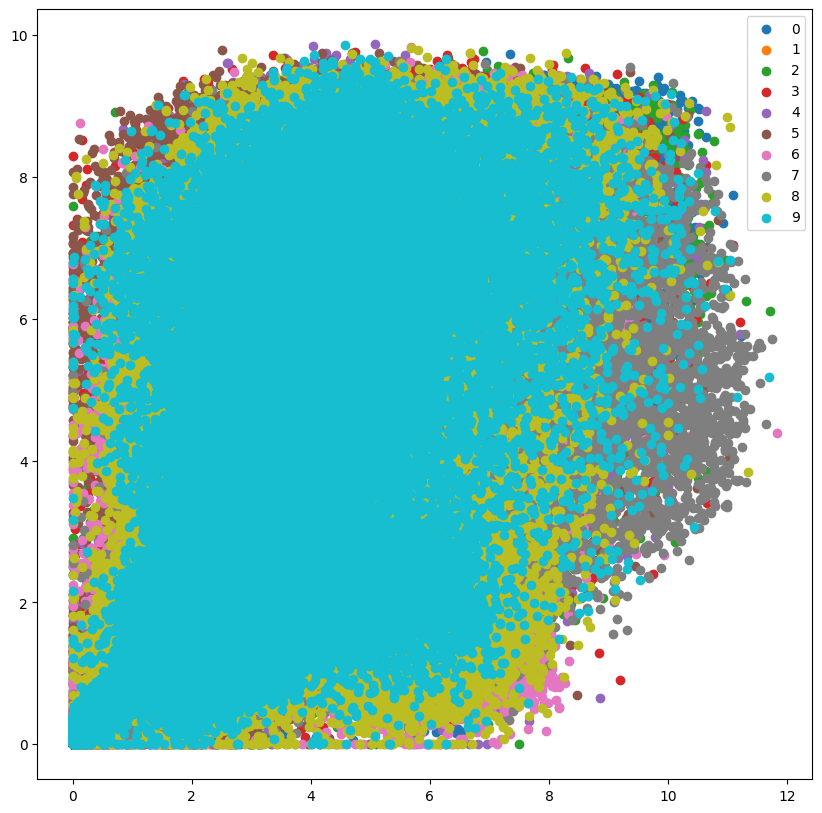

Training with latent_dim = 20
epoch [1/20], loss:0.0029
epoch [2/20], loss:0.0022
epoch [3/20], loss:0.0018
epoch [4/20], loss:0.0014
epoch [5/20], loss:0.0013
epoch [6/20], loss:0.0013
epoch [7/20], loss:0.0013
epoch [8/20], loss:0.0013
epoch [9/20], loss:0.0011
epoch [10/20], loss:0.0010
epoch [11/20], loss:0.0010
epoch [12/20], loss:0.0011
epoch [13/20], loss:0.0011
epoch [14/20], loss:0.0010
epoch [15/20], loss:0.0010
epoch [16/20], loss:0.0008
epoch [17/20], loss:0.0008
epoch [18/20], loss:0.0008
epoch [19/20], loss:0.0008
epoch [20/20], loss:0.0007


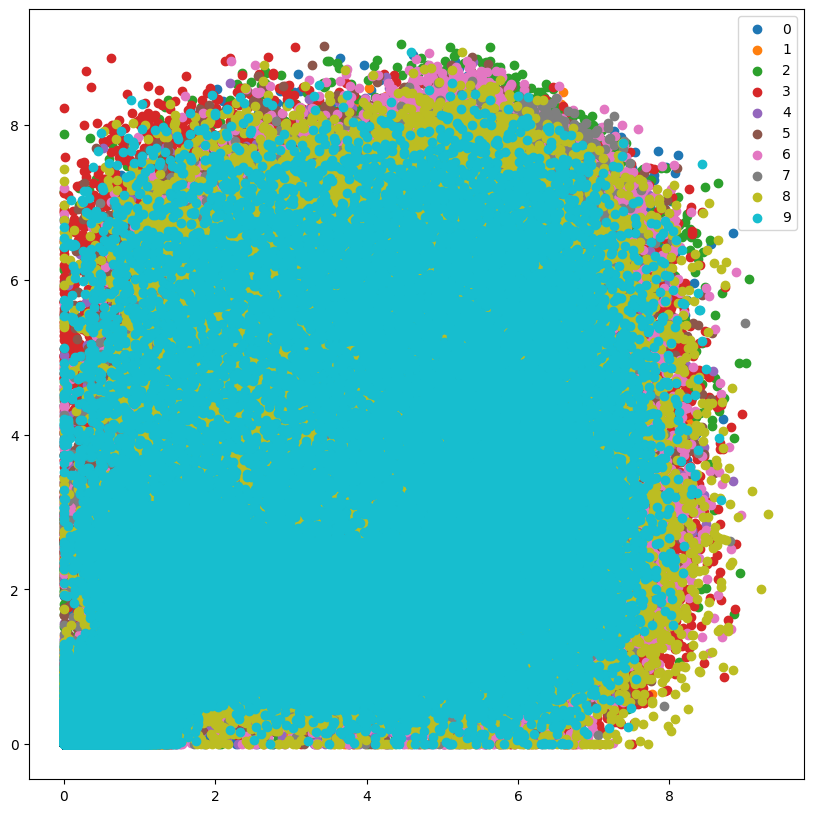

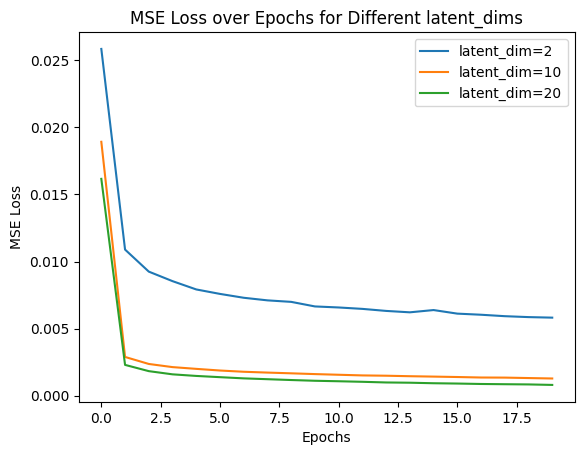

In [10]:

import matplotlib.pyplot as plt

num_epochs = 20
latent_dims = [2, 10, 20] 
losses_per_dim = {}

for dim in latent_dims:
    print(f"Training with latent_dim = {dim}")
    losses = train_AE_CNN(num_epochs, dim)
    losses_per_dim[dim] = losses
    
for latent_dim, losses in losses_per_dim.items():
    plt.plot(losses, label=f'latent_dim={latent_dim}')

plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('MSE Loss over Epochs for Different latent_dims')
plt.legend()
plt.show()


# Part2 Autoencoders vs GANs (30 points):
Still using the same notebook, add a DCGAN and train this on MNIST using a
comparable number of conv-layers, making sure to end up with DCGAN
architectures that use SIMILAR number of parameters compared to the
Neural Networks, Prof. C. Wallraven Page 2 of 2
autoencoders. Again, produce three different DCGAN models using generator
spaces of d = 2, d = 10, d = 50 training for n=20 epochs with properly set learning
rates.
Answer these questions:
1. Can you visualize the “latent” space of the DCGAN in the same way as the
autoencoder? Explain!
2. Which of the methods produces “better” digits?

In [11]:
class DiscriminatorNet(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.out = nn.Sequential(
            nn.Conv2d(128*4*4, latent_dim, kernel_size=1, stride=1, padding=0),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # Flatten and apply sigmoid
        x = x.view(-1, 128 * 4 * 4, 1, 1)
        x = self.out(x)
        return x

    # reset weights
    def reset(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.reset_parameters()
                m.weight.data.normal_(0.00, 0.02)

In [12]:
def numpy_to_plotly(arr):
    tmp = (arr-arr.min())/(arr.max()-arr.min())*255
    return np.dstack((tmp,tmp,tmp))

In [13]:
class GeneratorNet(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        
        # Initial linear layers to create a starting point for convolution
        self.conv0 = nn.ConvTranspose2d(latent_dim, 128 * 4 * 4, kernel_size=1, stride=1, padding=0)

        # Convolutional layers
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
        )
        self.out = nn.Tanh()

    def forward(self, x):
        # Project and reshape
        x = x.view(x.shape[0], latent_dim, 1, 1)
        x = self.conv0(x)
        x = x.view(x.shape[0], 128, 4, 4)

        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        #Apply Tanh
        return self.out(x)

    # reset weights
    def reset(self):
        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
                m.reset_parameters()
                m.weight.data.normal_(0.00, 0.02)


In [14]:

# Noise
def noise(size, latent_dim):
    n = torch.randn(size, latent_dim)
    if torch.cuda.is_available(): return n.cuda() 
    return n

In [15]:
def real_data_target(size, latent_dim):
    '''
    Tensor containing ones, with shape = size
    '''
    data = torch.ones(size, latent_dim, 1, 1)
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size, latent_dim):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = torch.zeros(size, latent_dim, 1, 1)
    if torch.cuda.is_available(): return data.cuda()
    return data

def train_discriminator(optimizer, real_data, fake_data, latent_dim):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    # Error is measured against real data targets
    error_real = loss(prediction_real, real_data_target(real_data.size(0), latent_dim))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    # Error is measured against fake targets
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0), latent_dim))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data, latent_dim):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    # Note that here the error is pretending to be real
    error = loss(prediction, real_data_target(prediction.size(0), latent_dim))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

Text(0, 0.5, 'number')

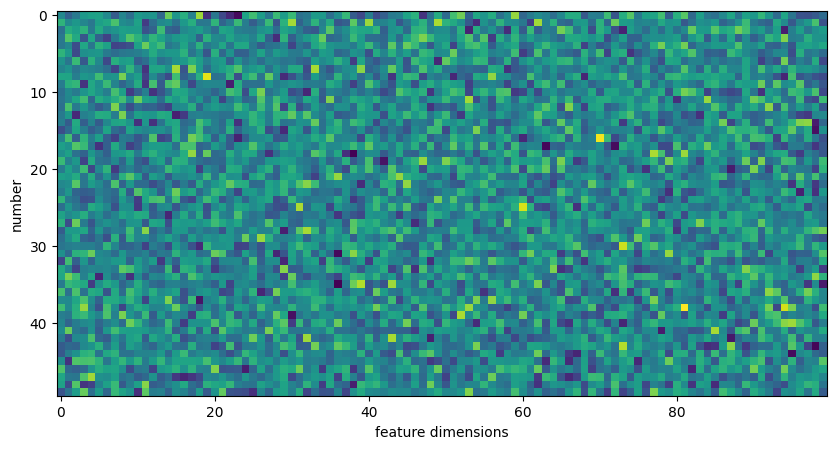

In [16]:
num_test_samples = 50
test_noise = noise(num_test_samples, 100)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.imshow(test_noise.cpu())
ax.set_xlabel('feature dimensions')
ax.set_ylabel('number')

In [17]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from ipywidgets import interact
fig = make_subplots(rows=4, cols=4)

for i in range(4):
    for j in range(4):
        fig.append_trace(go.Image(z=np.zeros((32,32,3))),row=i+1,col=j+1)
fig = go.FigureWidget(fig)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
)
fig


FigureWidget({
    'data': [{'type': 'image',
              'uid': '1392825d-10b0-453c-ac5f-53bda6cde6f1',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.],
                           ...,
                           [0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.]],
                   
                          [[0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.],
                           ...,
                           [0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.]],
                   
                          [[0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.],
                           ...,
                           [0., 0., 0.],
                           [0., 0., 0.],
  

In [18]:


latent_dim = 2

discriminator = DiscriminatorNet(latent_dim)
generator = GeneratorNet(latent_dim)

# summary(discriminator, torch.zeros((1, 1, 32, 32)), show_input=True)
# summary(generator, torch.zeros((1, 10, 1, 1)), show_input=True)

if torch.cuda.is_available(): device = torch.device('cuda')

discriminator.to(device=device)
generator.to(device=device)

# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function
loss = nn.BCELoss()

discriminator.reset()
generator.reset()

# Number of epochs for training the GAN
num_epochs = 20

t_start = time.time()
duration_avg = 0.0


test_noise = noise(num_test_samples, latent_dim)


for epoch in range(num_epochs):
    for n_batch, real_data in enumerate(dataloader):
        # 1. Train Discriminator with real images
        if torch.cuda.is_available():real_data[0] = real_data[0].to(device)
        # Generate fake data from noise, do not update
        # gradients here - hence add ".detach()"
        noi = noise(real_data[0].size(0), latent_dim)
        fake_data = generator(noi).detach()
        # Train discriminator with the real and fake data
        d_error, d_pred_real, d_pred_fake = \
                            train_discriminator(d_optimizer,                                    
                            real_data[0].float(), fake_data, latent_dim)

        # 2. Train Generator
        # Generate fake data from noise
        fake_data = generator(noi)#noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data, latent_dim)
        # Display Progress
        if (n_batch) % 50 == 0:
            test_images = generator(test_noise).data.cpu()
            p=0
            with fig.batch_update():
                for i in range(4):
                    for j in range(4):
                        tmp=test_images[p,0,:,:].numpy()
                        fig.data[p]['z']=numpy_to_plotly(tmp)
                        p+=1
            fig.update_layout(
                title={
                    'text':'epoch {0:} batch {1:} L(D)={2: .3f} L(G)={3: .3f} t={4: .1f}s/it'.format(
                        epoch,n_batch,d_error,g_error,duration_avg),
                    'xanchor':'center',
                    'x':0.5
                })
                
    t_end = time.time()
    duration_avg = (t_end - t_start) / (epoch + 1.0)

In [19]:
dataloaderSorted = torch.utils.data.DataLoader(trainset, batch_size=60000, shuffle=False, num_workers=4)

for n_batch, data in enumerate(dataloaderSorted):
    img, labels = data[0].to(device), data[1].detach().cpu().numpy()
plt.figure(figsize=(10,10))


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

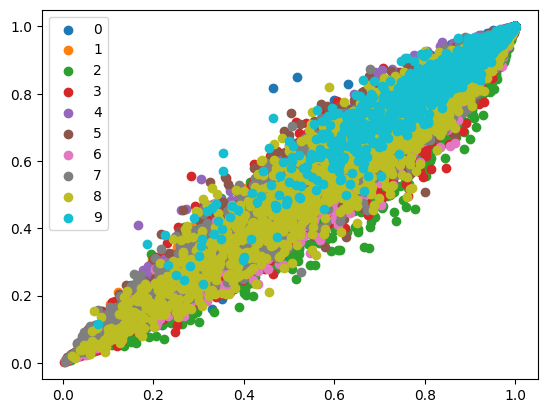

In [20]:
# don't forget to do this
discriminator.eval()
discriminator.to(device)
# go through each label
for l in np.arange(10):
    # find the indices
    inds = labels==l
    # select the images
    tmp = img[inds,:,:,:]
    tmp.to(device)
    # flatten them
    #tmp = tmp.view(tmp.size(0), -1)
    # put them through the model to get their 2D latent
    # space representation
    output = discriminator.forward(tmp).detach().cpu().numpy()
    # and scatter giving the label as the digit string
    plt.scatter(output[:,0],output[:,1],label=str(l))

plt.legend()
plt.show()

In [21]:


latent_dim = 10

discriminator = DiscriminatorNet(latent_dim)
generator = GeneratorNet(latent_dim)

# summary(discriminator, torch.zeros((1, 1, 32, 32)), show_input=True)
# summary(generator, torch.zeros((1, 10, 1, 1)), show_input=True)

if torch.cuda.is_available(): device = torch.device('cuda')

discriminator.to(device=device)
generator.to(device=device)

# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function
loss = nn.BCELoss()

discriminator.reset()
generator.reset()

# Number of epochs for training the GAN
num_epochs = 20

t_start = time.time()
duration_avg = 0.0


test_noise = noise(num_test_samples, latent_dim)


for epoch in range(num_epochs):
    for n_batch, real_data in enumerate(dataloader):
        # 1. Train Discriminator with real images
        if torch.cuda.is_available():real_data[0] = real_data[0].to(device)
        # Generate fake data from noise, do not update
        # gradients here - hence add ".detach()"
        noi = noise(real_data[0].size(0), latent_dim)
        fake_data = generator(noi).detach()
        # Train discriminator with the real and fake data
        d_error, d_pred_real, d_pred_fake = \
                            train_discriminator(d_optimizer,                                    
                            real_data[0].float(), fake_data, latent_dim)

        # 2. Train Generator
        # Generate fake data from noise
        fake_data = generator(noi)#noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data, latent_dim)
        # Display Progress
        if (n_batch) % 50 == 0:
            test_images = generator(test_noise).data.cpu()
            p=0
            with fig.batch_update():
                for i in range(4):
                    for j in range(4):
                        tmp=test_images[p,0,:,:].numpy()
                        fig.data[p]['z']=numpy_to_plotly(tmp)
                        p+=1
            fig.update_layout(
                title={
                    'text':'epoch {0:} batch {1:} L(D)={2: .3f} L(G)={3: .3f} t={4: .1f}s/it'.format(
                        epoch,n_batch,d_error,g_error,duration_avg),
                    'xanchor':'center',
                    'x':0.5
                })
                
    t_end = time.time()
    duration_avg = (t_end - t_start) / (epoch + 1.0)

In [22]:


latent_dim = 50

discriminator = DiscriminatorNet(latent_dim)
generator = GeneratorNet(latent_dim)

# summary(discriminator, torch.zeros((1, 1, 32, 32)), show_input=True)
# summary(generator, torch.zeros((1, 10, 1, 1)), show_input=True)

if torch.cuda.is_available(): device = torch.device('cuda')

discriminator.to(device=device)
generator.to(device=device)

# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function
loss = nn.BCELoss()

discriminator.reset()
generator.reset()

# Number of epochs for training the GAN
num_epochs = 20

t_start = time.time()
duration_avg = 0.0


test_noise = noise(num_test_samples, latent_dim)


for epoch in range(num_epochs):
    for n_batch, real_data in enumerate(dataloader):
        # 1. Train Discriminator with real images
        if torch.cuda.is_available():real_data[0] = real_data[0].to(device)
        # Generate fake data from noise, do not update
        # gradients here - hence add ".detach()"
        noi = noise(real_data[0].size(0), latent_dim)
        fake_data = generator(noi).detach()
        # Train discriminator with the real and fake data
        d_error, d_pred_real, d_pred_fake = \
                            train_discriminator(d_optimizer,                                    
                            real_data[0].float(), fake_data, latent_dim)

        # 2. Train Generator
        # Generate fake data from noise
        fake_data = generator(noi)#noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data, latent_dim)
        # Display Progress
        if (n_batch) % 50 == 0:
            test_images = generator(test_noise).data.cpu()
            p=0
            with fig.batch_update():
                for i in range(4):
                    for j in range(4):
                        tmp=test_images[p,0,:,:].numpy()
                        fig.data[p]['z']=numpy_to_plotly(tmp)
                        p+=1
            fig.update_layout(
                title={
                    'text':'epoch {0:} batch {1:} L(D)={2: .3f} L(G)={3: .3f} t={4: .1f}s/it'.format(
                        epoch,n_batch,d_error,g_error,duration_avg),
                    'xanchor':'center',
                    'x':0.5
                })
                
    t_end = time.time()
    duration_avg = (t_end - t_start) / (epoch + 1.0)